## Going Deeper 6. CAM, Grad-CAM 구현 및 비교

## 1. 데이터 준비

라벨 정보 및 bbox 정보를 포함하고 있는 데이터 셋 [cars196](https://www.tensorflow.org/datasets/catalog/cars196) 을 사용한다.  

cars196 데이터셋은 196개 등급의 자동차에 대한 16,185개의 이미지가 포함되어 있다. 데이터는 8,144개의 훈련 이미지와 8,041개의 테스트 이미지로 분할되어있다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cars196-train.tfrecord...:   0%|          | 0/8144 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling cars196-test.tfrecord...:   0%|          | 0/8041 [00:00<?, ? examples/s]

Dataset cars196 downloaded and prepared to /aiffel/tensorflow_datasets/cars196/2.0.1. Subsequent calls will reuse this data.


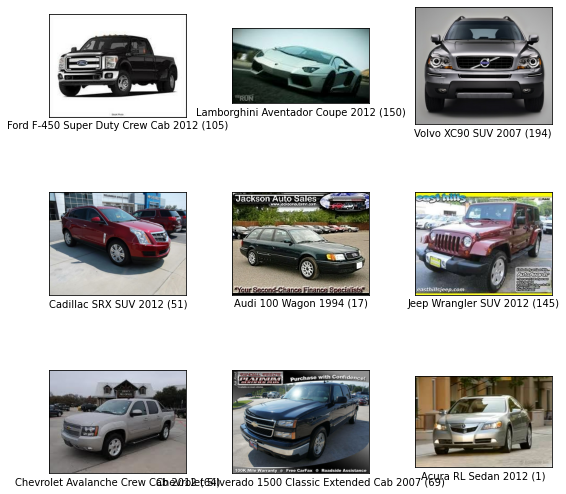

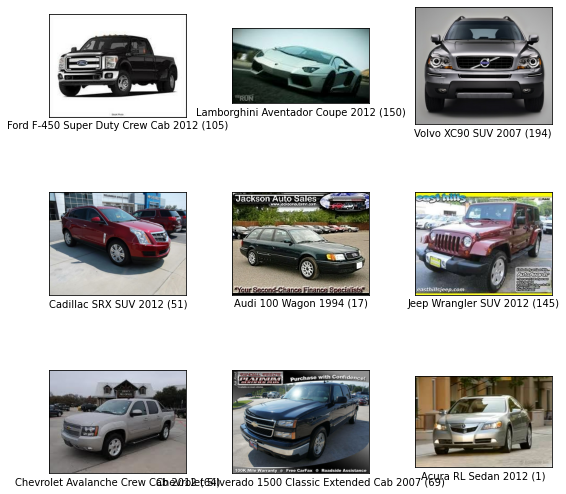

In [4]:
tfds.show_examples(ds_train, ds_info)

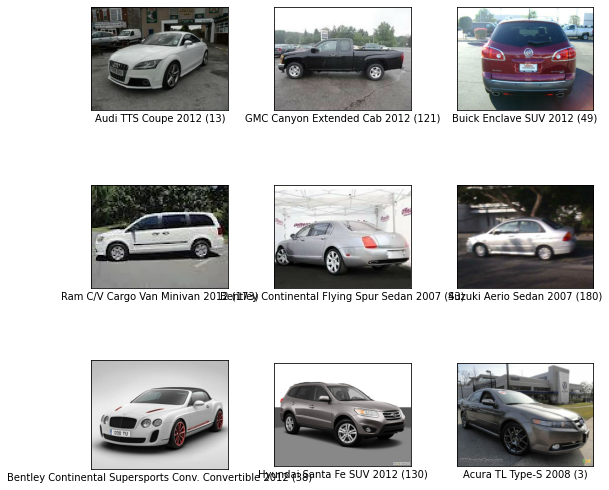

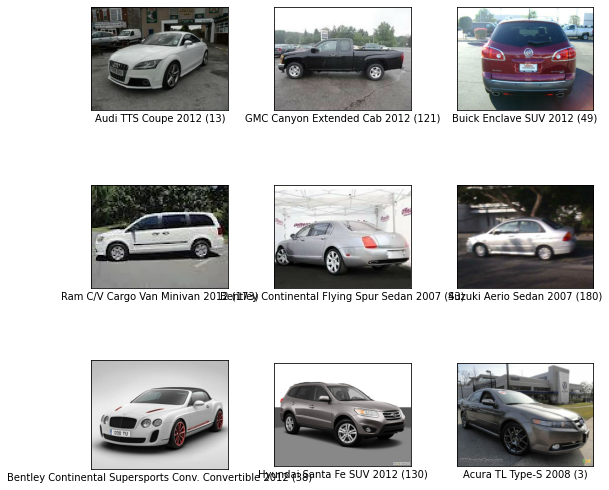

In [5]:
tfds.show_examples(ds_test, ds_info)

In [7]:
# 물체의 features 확인
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## 2. CAM을 위한 모델 생성

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## 3. CAM 모델 학습

In [10]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)


(16, 224, 224, 3)
(16,)


In [12]:
# 모델 학습
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 297s 520ms/step - loss: 4.9607 - accuracy: 0.0633 - val_loss: 5.4258 - val_accuracy: 0.0067
Epoch 2/15
509/509 [==============================] - 254s 499ms/step - loss: 2.0153 - accuracy: 0.5549 - val_loss: 1.8960 - val_accuracy: 0.5108
Epoch 3/15
509/509 [==============================] - 254s 499ms/step - loss: 0.7885 - accuracy: 0.8432 - val_loss: 1.2797 - val_accuracy: 0.6658
Epoch 4/15
509/509 [==============================] - 254s 499ms/step - loss: 0.2266 - accuracy: 0.9776 - val_loss: 1.1327 - val_accuracy: 0.6992
Epoch 5/15
509/509 [==============================] - 254s 499ms/step - loss: 0.0719 - accuracy: 0.9958 - val_loss: 1.0690 - val_accuracy: 0.7159
Epoch 6/15
509/509 [==============================] - 254s 499ms/step - loss: 0.0354 - accuracy: 0.9989 - val_loss: 1.0579 - val_accuracy: 0.7207
Epoch 7/15
509/509 [==============================] - 254s 499ms/step - loss: 0.0246 - accuracy: 0.9993 - val_loss: 1.0354 -

In [13]:
import os

# 학습된 모델 저장
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_project_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## 4. CAM 구현

In [16]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

12


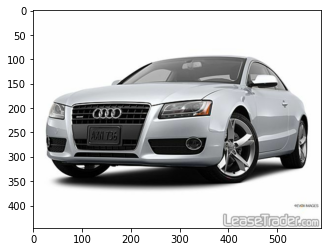

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

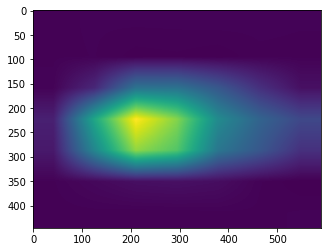

In [19]:
cam_image = generate_cam(cam_model, item)  # CAM 이미지 생성
plt.imshow(cam_image)

### CAM, 원본이미지와 합치기

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

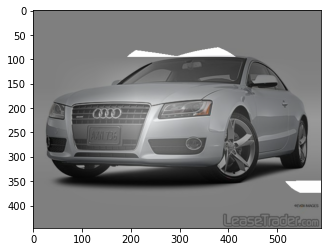

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 5. Grad-CAM

116


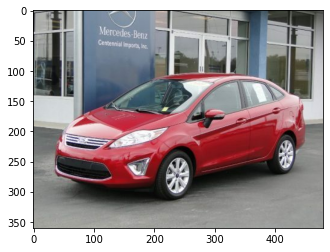

In [22]:
# 새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

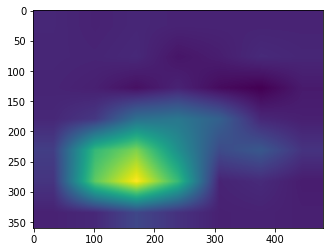

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

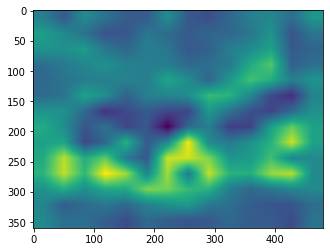

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

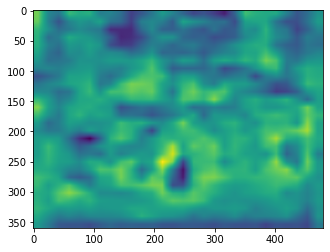

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### Grad-CAM, 원본이미지와 합치기

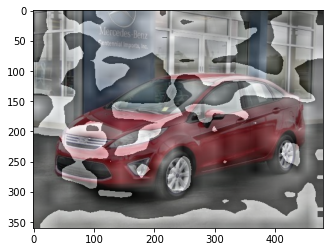

In [29]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 6. Detection with CAM

### Bounding Box

160


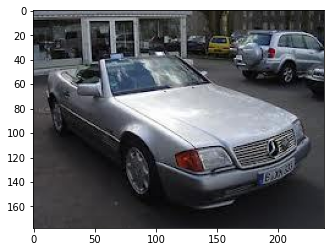

In [30]:
# 새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

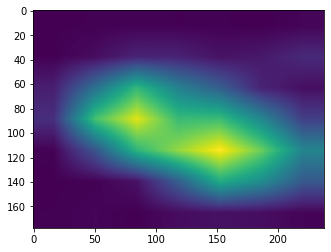

In [31]:
# CAM 이미지 뽑기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

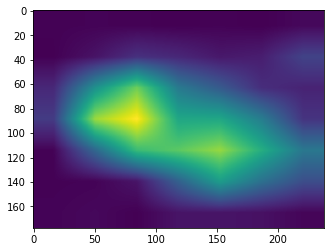

In [36]:
# Grad-CAM 이미지 뽑기
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [32]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [33]:
rect = get_bbox(cam_image)
rect

array([[  0,  22],
       [237,  22],
       [237, 164],
       [  0, 164]])

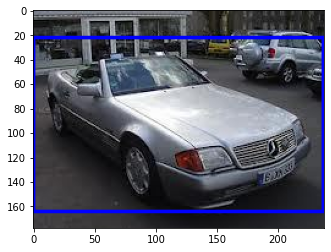

In [34]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [37]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ -2,  25],
       [236,  16],
       [242, 173],
       [  2, 182]])

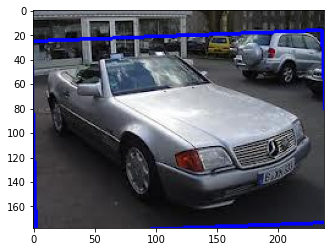

In [39]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

## 7. Intersection Over Union

In [35]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [43]:
cam_pred_bbox = rect_to_minmax(rect, item['image'])
cam_pred_bbox

[0.12359550561797752, 0.0, 0.9213483146067416, 0.9957983193277311]

In [54]:
grad_cam_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_cam_pred_bbox

[0.0898876404494382,
 -0.008403361344537815,
 1.0224719101123596,
 1.0168067226890756]

In [55]:
# 이 데이터의 ground truth box 확인
ground_truth_bbox = item['bbox']
ground_truth_bbox

array([0.20224719, 0.04201681, 0.96067417, 0.96218485], dtype=float32)

In [46]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [56]:
get_iou(cam_pred_bbox, ground_truth_bbox)

0.7966578319352763

In [57]:
get_iou(grad_cam_pred_bbox, ground_truth_bbox)

0.7299279003964566

## 8. CAM, Grad-CAM 비교

Text(0.5, 1.0, 'Grad-CAM (IoU : 0.73)')

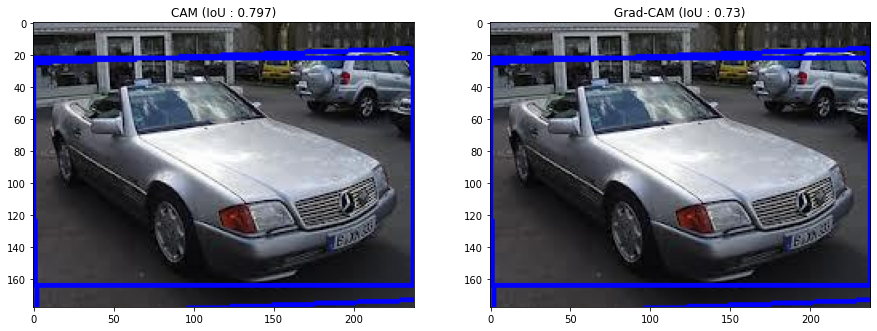

In [64]:
image = copy.deepcopy(item['image'])

image_cam = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image_grad_cam = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(image_cam)
plt.title('CAM (IoU : 0.797)')
plt.subplot(1,2,2)
plt.imshow(image_grad_cam)
plt.title('Grad-CAM (IoU : 0.73)')

# Results

결과적으로 CAM 과 Grad-CAM로 구한 Bounding Box 의 IoU 가 둘 다 상당히 높은 수준으로 나온 것을 확인 할 수 있다. 그 이유는 테스트 과정에서 사용된 자동차 이미지의 노이즈가 적고, 차의 주요 특징적인 부분이 잘 묘사되어있는 것으로 보인다.  

또한 주요 특징을 살펴보면 자동차의 브랜드와 핵심 디자인 부분인 차의 앞부분에 집중하여 자동차를 찾아내는 모습을 확인 할 수 있다. 또한 테스트 과정에 사용된 자동차 이미지의 경우, 차의 뒷쪽에도 차의 앞쪽만큼의 특징을 잡아낸 것을 확인 할 수 있는데, 이것은 테스트과정에서 사용된 자동차가 오픈카이므로 해당 특징을 잘 파악한 것으로 보인다.